# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd

from joblib import dump, load
#import missingno as msno
from time import time
from collections import OrderedDict, Counter
from tqdm.auto import tqdm, trange
tqdm.pandas()
#import pyarrow
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import boto3
from sagemaker import get_execution_role
#import pyarrow.parquet as pq

sns.set(style="darkgrid")
role = get_execution_role()
bucket='avratodataset3'

# magic word for producing visualizations in notebook
%matplotlib inline

In [2]:
#import pyarrow
#import fastparquet 
#import gzip

In [3]:
# load in the data
data_key = 'Udacity_AZDIAS_052018.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)
azdias=pd.read_csv(data_location,sep=';')
data_key = 'Udacity_CUSTOMERS_052018.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)
customers=pd.read_csv(data_location,sep=';')

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
#customers=pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';', low_memory=True)
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [5]:
#azdias=pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';', low_memory=True, skiprows=500000)
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


the preprocessing and analysis are explained in the previous notebook

In [6]:
from functions import *

def preprocess(azdias):
    
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')
    drop_features = ['D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM']

    azdias = azdias.drop(drop_features, axis=1)
    azdias = replace_missing_or_unknown(azdias, feat_info)
    column_nans = nans_count(azdias)
    column_nan_threshold = 75

    nans_to_drop = column_nans[column_nans['nan_count'] > column_nan_threshold].index.tolist()
    azdias.drop(nans_to_drop, axis=1, inplace=True)
    drop_features = drop_features + nans_to_drop
    row_nans = nans_count(azdias, axis=1)
    
    initial_data = feat_info.groupby('type').agg('count')

    feat_info_afer_drop = feat_info[feat_info['attribute'].isin(azdias.columns.values)]
    after_column_drop = feat_info_afer_drop.groupby('type').agg('count')
    categorical_features = feat_info_afer_drop[feat_info_afer_drop['type'] == 'categorical']['attribute'].tolist()
    azdias['OST_WEST_KZ'] = azdias['OST_WEST_KZ'].map({'W': 1, 'O': 2})
    azdias[categorical_features] = azdias[categorical_features].fillna(azdias[categorical_features].mode().iloc[0])
    
    cat_numeric = list(set(categorical_features)-set(['CAMEO_DEU_2015']))
    azdias[cat_numeric] = azdias[cat_numeric].astype('int8')
    azdias[categorical_features] = azdias[categorical_features].astype('category')
    
    feat_info = feat_info[feat_info['attribute'].isin(azdias.columns.values)]
    mixed_type_features = feat_info[feat_info['type'] == 'mixed']['attribute']
    
    azdias[mixed_type_features] = azdias[mixed_type_features].fillna(azdias[mixed_type_features].mode().iloc[0])
    
    
    decade = {'1.0': 1, '2.0': 1, '3.0': 2, '4.0': 2, '5.0': 3, '6.0': 3, '7.0': 3, '8.0': 4, '9.0': 4, '10.0': 5, 
          '11.0': 5, '12.0': 5, '13.0': 5, '14.0': 6, '15.0': 6}

    movement = {'1.0': 1, '2.0': 2, '3.0': 1, '4.0': 2, '5.0': 1, '6.0': 2, '7.0': 2, '8.0': 1, '9.0': 2, '10.0': 1, 
            '11.0': 2, '12.0': 1, '13.0': 2, '14.0': 1, '15.0': 2}

    azdias['PRAEGENDE_JUGENDJAHRE'] = azdias['PRAEGENDE_JUGENDJAHRE'].astype('str')
    azdias['PRAEGENDE_JUGENDJAHRE_DECADE'] = azdias['PRAEGENDE_JUGENDJAHRE'].replace(decade)
    azdias['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = azdias['PRAEGENDE_JUGENDJAHRE'].replace(movement)
    azdias = azdias.drop('PRAEGENDE_JUGENDJAHRE', axis=1)
    decade_movement = ['PRAEGENDE_JUGENDJAHRE_DECADE', 'PRAEGENDE_JUGENDJAHRE_MOVEMENT']
    azdias[decade_movement] = azdias[decade_movement].astype('int8').astype('category')

    rep={'B':1, 'A':2, 'C':3, 'D':4, 'E':5, 'F':6}
    azdias['CAMEO_DEU_2015_1'] = azdias['CAMEO_DEU_2015'].apply(lambda x: list(str(x))[0])
    azdias['CAMEO_DEU_2015_2'] = azdias['CAMEO_DEU_2015'].apply(lambda x: list(str(x))[1])
    azdias = azdias.drop('CAMEO_DEU_2015', axis=1)
    azdias['CAMEO_DEU_2015_2'] = azdias['CAMEO_DEU_2015_2'].replace(rep)
    azdias[['CAMEO_DEU_2015_1','CAMEO_DEU_2015_2']] = azdias[['CAMEO_DEU_2015_1','CAMEO_DEU_2015_2']].astype('int8').astype('category')
    
    
    
    azdias['CAMEO_INTL_2015_WEALTH'] = azdias['CAMEO_INTL_2015'].apply(lambda x: list(str(x))[0])
    azdias['CAMEO_INTL_2015_LIFE_STAGE'] = azdias['CAMEO_INTL_2015'].apply(lambda x: list(str(x))[1])
    azdias = azdias.drop('CAMEO_INTL_2015', axis=1)
    
    wealth_life = ['CAMEO_INTL_2015_WEALTH', 'CAMEO_INTL_2015_LIFE_STAGE']
    azdias[wealth_life] = azdias[wealth_life].astype('int8').astype('category')
    
    feat_info = feat_info[feat_info['attribute'].isin(azdias.columns.values)]
    remaining_mix_type = feat_info[feat_info['type'] == 'mixed']['attribute']
    azdias[remaining_mix_type] = azdias[remaining_mix_type].astype('int8').astype('category')
    
    ordinal_features = feat_info_afer_drop[feat_info_afer_drop['type'] == 'ordinal']['attribute'].tolist()
    azdias[ordinal_features] = azdias[ordinal_features].fillna(azdias[ordinal_features].mode().iloc[0])
    azdias[ordinal_features] = azdias[ordinal_features].astype('int8').astype('category')
    
    interval_features = feat_info[feat_info['type'] == 'interval']['attribute'].tolist()
    azdias[interval_features] = azdias[interval_features].fillna(azdias[interval_features].mode().iloc[0])
    azdias[interval_features] = azdias[interval_features].astype('int8').astype('category')
    
    numeric_features = feat_info[feat_info['type'] == 'numeric']['attribute'].tolist()
    azdias[numeric_features] = azdias[numeric_features].fillna(azdias[numeric_features].median())
    azdias[numeric_features] = azdias[numeric_features].astype('int32')
    
    return azdias

In [7]:
azdias = preprocess(azdias)
azdias, _ = reduce_mem_usage(azdias)

Processing AGER_TYP



Processing ALTERSKATEGORIE_GROB



Processing ALTER_HH



Processing ANREDE_KZ



Processing BALLRAUM



Processing CAMEO_DEUG_2015



Processing CAMEO_DEU_2015



Processing CAMEO_INTL_2015



Processing CJT_GESAMTTYP



Processing D19_BANKEN_ANZ_12



Processing D19_BANKEN_ANZ_24



Processing D19_BANKEN_DATUM



Processing D19_BANKEN_DIREKT



Processing D19_BANKEN_GROSS



Processing D19_BANKEN_LOKAL



Processing D19_BANKEN_OFFLINE_DATUM



Processing D19_BANKEN_ONLINE_DATUM



Processing D19_BANKEN_REST



Processing D19_BEKLEIDUNG_GEH



Processing D19_BEKLEIDUNG_REST



Processing D19_BILDUNG



Processing D19_BIO_OEKO



Processing D19_BUCH_CD



Processing D19_DIGIT_SERV



Processing D19_DROGERIEARTIKEL



Processing D19_ENERGIE



Processing D19_FREIZEIT



Processing D19_GARTEN



Processing D19_GESAMT_ANZ_12



Processing D19_GESAMT_ANZ_24



Processing D19_GESAMT_DATUM



Processing D19_GESAMT_OFFLINE_DATUM



Processing D19_GESAMT_ONLINE_DATUM



Processing D19_HANDWERK



Processing D19_HAUS_DEKO



Processing D19_KINDERARTIKEL



Processing KK_KUNDENTYP



Processing D19_KOSMETIK



Processing D19_LEBENSMITTEL



Processing D19_LOTTO



Processing D19_NAHRUNGSERGAENZUNG



Processing D19_RATGEBER



Processing D19_REISEN



Processing D19_SAMMELARTIKEL



Processing D19_SCHUHE



Processing D19_SONSTIGE



Processing D19_TECHNIK



Processing D19_TELKO_ANZ_12



Processing D19_TELKO_ANZ_24



Processing D19_TELKO_DATUM



Processing D19_TELKO_MOBILE



Processing D19_TELKO_OFFLINE_DATUM



Processing D19_TELKO_ONLINE_DATUM



Processing D19_TELKO_REST



Processing D19_TIERARTIKEL



Processing D19_VERSAND_ANZ_12



Processing D19_VERSAND_ANZ_24



Processing D19_VERSAND_DATUM



Processing D19_VERSAND_OFFLINE_DATUM



Processing D19_VERSAND_ONLINE_DATUM



Processing D19_VERSAND_REST



Processing D19_VERSICHERUNGEN



Processing D19_VERSI_ANZ_12



Processing D19_VERSI_ANZ_24



Processing D19_VOLLSORTIMENT



Processing D19_WEIN_FEINKOST



Processing EWDICHTE



Processing FINANZTYP



Processing FINANZ_ANLEGER



Processing FINANZ_HAUSBAUER



Processing FINANZ_MINIMALIST



Processing FINANZ_SPARER



Processing FINANZ_UNAUFFAELLIGER



Processing FINANZ_VORSORGER



Processing GEBAEUDETYP



Processing GEBURTSJAHR



Processing HEALTH_TYP



Processing HH_EINKOMMEN_SCORE



Processing INNENSTADT



Processing KBA05_ALTER1



Processing KBA05_ALTER2



Processing KBA05_ALTER3



Processing KBA05_ALTER4



Processing KBA05_ANHANG



Processing KBA05_ANTG1



Processing KBA05_ANTG2



Processing KBA05_ANTG3



Processing KBA05_ANTG4



Processing KBA05_AUTOQUOT



Processing KBA05_BAUMAX



Processing KBA05_CCM1



Processing KBA05_CCM2



Processing KBA05_CCM3



Processing KBA05_CCM4



Processing KBA05_DIESEL



Processing KBA05_FRAU



Processing KBA05_GBZ



Processing KBA05_HERST1



Processing KBA05_HERST2



Processing KBA05_HERST3



Processing KBA05_HERST4



Processing KBA05_HERST5



Processing KBA05_HERSTTEMP



Processing KBA05_KRSAQUOT



Processing KBA05_KRSHERST1



Processing KBA05_KRSHERST2



Processing KBA05_KRSHERST3



Processing KBA05_KRSKLEIN



Processing KBA05_KRSOBER



Processing KBA05_KRSVAN



Processing KBA05_KRSZUL



Processing KBA05_KW1



Processing KBA05_KW2



Processing KBA05_KW3



Processing KBA05_MAXAH



Processing KBA05_MAXBJ



Processing KBA05_MAXHERST



Processing KBA05_MAXSEG



Processing KBA05_MAXVORB



Processing KBA05_MOD1



Processing KBA05_MOD2



Processing KBA05_MOD3



Processing KBA05_MOD4



Processing KBA05_MOD8



Processing KBA05_MODTEMP



Processing KBA05_MOTOR



Processing KBA05_MOTRAD



Processing KBA05_SEG1



Processing KBA05_SEG10



Processing KBA05_SEG2



Processing KBA05_SEG3



Processing KBA05_SEG4



Processing KBA05_SEG5



Processing KBA05_SEG6



Processing KBA05_SEG7



Processing KBA05_SEG8



Processing KBA05_SEG9



Processing KBA05_VORB0



Processing KBA05_VORB1



Processing KBA05_VORB2



Processing KBA05_ZUL1



Processing KBA05_ZUL2



Processing KBA05_ZUL3



Processing KBA05_ZUL4



Processing KBA13_ALTERHALTER_30



Processing KBA13_ALTERHALTER_45



Processing KBA13_ALTERHALTER_60



Processing KBA13_ALTERHALTER_61



Processing KBA13_AUDI



Processing KBA13_AUTOQUOTE



Processing KBA13_BJ_1999



Processing KBA13_BJ_2000



Processing KBA13_BJ_2004



Processing KBA13_BJ_2006



Processing KBA13_BJ_2008



Processing KBA13_BJ_2009



Processing KBA13_BMW



Processing KBA13_CCM_1000



Processing KBA13_CCM_1200



Processing KBA13_CCM_1400



Processing KBA13_CCM_0_1400



Processing KBA13_CCM_1500



Processing KBA13_CCM_1600



Processing KBA13_CCM_1800



Processing KBA13_CCM_2000



Processing KBA13_CCM_2500



Processing KBA13_CCM_2501



Processing KBA13_CCM_3000



Processing KBA13_CCM_3001



Processing KBA13_FAB_ASIEN



Processing KBA13_FAB_SONSTIGE



Processing KBA13_FIAT



Processing KBA13_FORD



Processing KBA13_HALTER_20



Processing KBA13_HALTER_25



Processing KBA13_HALTER_30



Processing KBA13_HALTER_35



Processing KBA13_HALTER_40



Processing KBA13_HALTER_45



Processing KBA13_HALTER_50



Processing KBA13_HALTER_55



Processing KBA13_HALTER_60



Processing KBA13_HALTER_65



Processing KBA13_HALTER_66



Processing KBA13_HERST_ASIEN



Processing KBA13_HERST_AUDI_VW



Processing KBA13_HERST_BMW_BENZ



Processing KBA13_HERST_EUROPA



Processing KBA13_HERST_FORD_OPEL



Processing KBA13_HERST_SONST



Processing KBA13_KMH_110



Processing KBA13_KMH_140



Processing KBA13_KMH_180



Processing KBA13_KMH_0_140



Processing KBA13_KMH_140_210



Processing KBA13_KMH_211



Processing KBA13_KMH_250



Processing KBA13_KMH_251



Processing KBA13_KRSAQUOT



Processing KBA13_KRSHERST_AUDI_VW



Processing KBA13_KRSHERST_BMW_BENZ



Processing KBA13_KRSHERST_FORD_OPEL



Processing KBA13_KRSSEG_KLEIN



Processing KBA13_KRSSEG_OBER



Processing KBA13_KRSSEG_VAN



Processing KBA13_KRSZUL_NEU



Processing KBA13_KW_30



Processing KBA13_KW_40



Processing KBA13_KW_50



Processing KBA13_KW_60



Processing KBA13_KW_0_60



Processing KBA13_KW_70



Processing KBA13_KW_61_120



Processing KBA13_KW_80



Processing KBA13_KW_90



Processing KBA13_KW_110



Processing KBA13_KW_120



Processing KBA13_KW_121



Processing KBA13_MAZDA



Processing KBA13_MERCEDES



Processing KBA13_MOTOR



Processing KBA13_NISSAN



Processing KBA13_OPEL



Processing KBA13_PEUGEOT



Processing KBA13_RENAULT



Processing KBA13_SEG_GELAENDEWAGEN



Processing KBA13_SEG_GROSSRAUMVANS



Processing KBA13_SEG_KLEINST



Processing KBA13_SEG_KLEINWAGEN



Processing KBA13_SEG_KOMPAKTKLASSE



Processing KBA13_SEG_MINIVANS



Processing KBA13_SEG_MINIWAGEN



Processing KBA13_SEG_MITTELKLASSE



Processing KBA13_SEG_OBEREMITTELKLASSE



Processing KBA13_SEG_OBERKLASSE



Processing KBA13_SEG_SONSTIGE



Processing KBA13_SEG_SPORTWAGEN



Processing KBA13_SEG_UTILITIES



Processing KBA13_SEG_VAN



Processing KBA13_SEG_WOHNMOBILE



Processing KBA13_SITZE_4



Processing KBA13_SITZE_5



Processing KBA13_SITZE_6



Processing KBA13_TOYOTA



Processing KBA13_VORB_0



Processing KBA13_VORB_1



Processing KBA13_VORB_1_2



Processing KBA13_VORB_2



Processing KBA13_VORB_3



Processing KBA13_VW



Processing KKK



Processing LP_FAMILIE_FEIN



Processing LP_FAMILIE_GROB



Processing LP_LEBENSPHASE_FEIN



Processing LP_LEBENSPHASE_GROB



Processing LP_STATUS_FEIN



Processing LP_STATUS_GROB



Processing NATIONALITAET_KZ



Processing ORTSGR_KLS9



Processing OST_WEST_KZ



Processing PLZ8_ANTG1



Processing PLZ8_ANTG2



Processing PLZ8_ANTG3



Processing PLZ8_ANTG4



Processing PLZ8_GBZ



Processing PLZ8_HHZ



Processing PRAEGENDE_JUGENDJAHRE



Processing REGIOTYP



Processing RELAT_AB



Processing RETOURTYP_BK_S



Processing SEMIO_DOM



Processing SEMIO_ERL



Processing SEMIO_FAM



Processing SEMIO_KAEM



Processing SEMIO_KRIT



Processing SEMIO_KULT



Processing SEMIO_LUST



Processing SEMIO_MAT



Processing SEMIO_PFLICHT



Processing SEMIO_RAT



Processing SEMIO_REL



Processing SEMIO_SOZ



Processing SEMIO_TRADV



Processing SEMIO_VERT



Processing SHOPPER_TYP



Processing TITEL_KZ



Processing VERS_TYP



Processing WOHNDAUER_2008



Processing WOHNLAGE



Processing W_KEIT_KIND_HH



Processing ZABEOTYP



Processing ARBEIT



Processing ALTERSKATEGORIE_FEIN



Processing D19_SOZIALES



Processing D19_TELKO_ONLINE_QUOTE_12



Processing D19_VERSI_DATUM



Processing D19_VERSI_OFFLINE_DATUM



Processing D19_VERSI_ONLINE_DATUM



Processing KBA13_ANTG1



Processing KBA13_ANTG2



Processing KBA13_ANTG3



Processing KBA13_ANTG4



Processing KBA13_CCM_1401_2500



Processing KBA13_GBZ



Processing KBA13_HHZ



Processing KBA13_KMH_210



Processing KOMBIALTER



Processing KBA13_BAUMAX



Memory usage of dataframe:  314.5424518585205  MB



___MEMORY USAGE AFTER COMPLETION:___
Memory usage is: 277.99526500701904 MB
This is 88.38% of the initial size


In [8]:
extra_columns = ['ONLINE_PURCHASE', 'PRODUCT_GROUP', 'CUSTOMER_GROUP']
customers_extra = customers[extra_columns + ['LNR']]
customers = customers.drop(extra_columns, axis=1)
customers = preprocess(customers)
customers = pd.DataFrame(customers, columns=azdias.columns)
customers, _ = reduce_mem_usage(customers)
customers_exta = pd.merge(customers, customers_extra, how='inner', on='LNR')

Processing AGER_TYP



Processing ALTERSKATEGORIE_GROB



Processing ALTER_HH



Processing ANREDE_KZ



Processing BALLRAUM



Processing CAMEO_DEUG_2015



Processing CAMEO_DEU_2015



Processing CAMEO_INTL_2015



Processing CJT_GESAMTTYP



Processing D19_BANKEN_ANZ_12



Processing D19_BANKEN_ANZ_24



Processing D19_BANKEN_DATUM



Processing D19_BANKEN_DIREKT



Processing D19_BANKEN_GROSS



Processing D19_BANKEN_LOKAL



Processing D19_BANKEN_OFFLINE_DATUM



Processing D19_BANKEN_ONLINE_DATUM



Processing D19_BANKEN_REST



Processing D19_BEKLEIDUNG_GEH



Processing D19_BEKLEIDUNG_REST



Processing D19_BILDUNG



Processing D19_BIO_OEKO



Processing D19_BUCH_CD



Processing D19_DIGIT_SERV



Processing D19_DROGERIEARTIKEL



Processing D19_ENERGIE



Processing D19_FREIZEIT



Processing D19_GARTEN



Processing D19_GESAMT_ANZ_12



Processing D19_GESAMT_ANZ_24



Processing D19_GESAMT_DATUM



Processing D19_GESAMT_OFFLINE_DATUM



Processing D19_GESAMT_ONLINE_DATUM



Processing D19_HANDWERK



Processing D19_HAUS_DEKO



Processing D19_KINDERARTIKEL



Processing KK_KUNDENTYP



Processing D19_KOSMETIK



Processing D19_LEBENSMITTEL



Processing D19_LOTTO



Processing D19_NAHRUNGSERGAENZUNG



Processing D19_RATGEBER



Processing D19_REISEN



Processing D19_SAMMELARTIKEL



Processing D19_SCHUHE



Processing D19_SONSTIGE



Processing D19_TECHNIK



Processing D19_TELKO_ANZ_12



Processing D19_TELKO_ANZ_24



Processing D19_TELKO_DATUM



Processing D19_TELKO_MOBILE



Processing D19_TELKO_OFFLINE_DATUM



Processing D19_TELKO_ONLINE_DATUM



Processing D19_TELKO_REST



Processing D19_TIERARTIKEL



Processing D19_VERSAND_ANZ_12



Processing D19_VERSAND_ANZ_24



Processing D19_VERSAND_DATUM



Processing D19_VERSAND_OFFLINE_DATUM



Processing D19_VERSAND_ONLINE_DATUM



Processing D19_VERSAND_REST



Processing D19_VERSICHERUNGEN



Processing D19_VERSI_ANZ_12



Processing D19_VERSI_ANZ_24



Processing D19_VOLLSORTIMENT



Processing D19_WEIN_FEINKOST



Processing EWDICHTE



Processing FINANZTYP



Processing FINANZ_ANLEGER



Processing FINANZ_HAUSBAUER



Processing FINANZ_MINIMALIST



Processing FINANZ_SPARER



Processing FINANZ_UNAUFFAELLIGER



Processing FINANZ_VORSORGER



Processing GEBAEUDETYP



Processing GEBURTSJAHR



Processing HEALTH_TYP



Processing HH_EINKOMMEN_SCORE



Processing INNENSTADT



Processing KBA05_ALTER1



Processing KBA05_ALTER2



Processing KBA05_ALTER3



Processing KBA05_ALTER4



Processing KBA05_ANHANG



Processing KBA05_ANTG1



Processing KBA05_ANTG2



Processing KBA05_ANTG3



Processing KBA05_ANTG4



Processing KBA05_AUTOQUOT



Processing KBA05_BAUMAX



Processing KBA05_CCM1



Processing KBA05_CCM2



Processing KBA05_CCM3



Processing KBA05_CCM4



Processing KBA05_DIESEL



Processing KBA05_FRAU



Processing KBA05_GBZ



Processing KBA05_HERST1



Processing KBA05_HERST2



Processing KBA05_HERST3



Processing KBA05_HERST4



Processing KBA05_HERST5



Processing KBA05_HERSTTEMP



Processing KBA05_KRSAQUOT



Processing KBA05_KRSHERST1



Processing KBA05_KRSHERST2



Processing KBA05_KRSHERST3



Processing KBA05_KRSKLEIN



Processing KBA05_KRSOBER



Processing KBA05_KRSVAN



Processing KBA05_KRSZUL



Processing KBA05_KW1



Processing KBA05_KW2



Processing KBA05_KW3



Processing KBA05_MAXAH



Processing KBA05_MAXBJ



Processing KBA05_MAXHERST



Processing KBA05_MAXSEG



Processing KBA05_MAXVORB



Processing KBA05_MOD1



Processing KBA05_MOD2



Processing KBA05_MOD3



Processing KBA05_MOD4



Processing KBA05_MOD8



Processing KBA05_MODTEMP



Processing KBA05_MOTOR



Processing KBA05_MOTRAD



Processing KBA05_SEG1



Processing KBA05_SEG10



Processing KBA05_SEG2



Processing KBA05_SEG3



Processing KBA05_SEG4



Processing KBA05_SEG5



Processing KBA05_SEG6



Processing KBA05_SEG7



Processing KBA05_SEG8



Processing KBA05_SEG9



Processing KBA05_VORB0



Processing KBA05_VORB1



Processing KBA05_VORB2



Processing KBA05_ZUL1



Processing KBA05_ZUL2



Processing KBA05_ZUL3



Processing KBA05_ZUL4



Processing KBA13_ALTERHALTER_30



Processing KBA13_ALTERHALTER_45



Processing KBA13_ALTERHALTER_60



Processing KBA13_ALTERHALTER_61



Processing KBA13_AUDI



Processing KBA13_AUTOQUOTE



Processing KBA13_BJ_1999



Processing KBA13_BJ_2000



Processing KBA13_BJ_2004



Processing KBA13_BJ_2006



Processing KBA13_BJ_2008



Processing KBA13_BJ_2009



Processing KBA13_BMW



Processing KBA13_CCM_1000



Processing KBA13_CCM_1200



Processing KBA13_CCM_1400



Processing KBA13_CCM_0_1400



Processing KBA13_CCM_1500



Processing KBA13_CCM_1600



Processing KBA13_CCM_1800



Processing KBA13_CCM_2000



Processing KBA13_CCM_2500



Processing KBA13_CCM_2501



Processing KBA13_CCM_3000



Processing KBA13_CCM_3001



Processing KBA13_FAB_ASIEN



Processing KBA13_FAB_SONSTIGE



Processing KBA13_FIAT



Processing KBA13_FORD



Processing KBA13_HALTER_20



Processing KBA13_HALTER_25



Processing KBA13_HALTER_30



Processing KBA13_HALTER_35



Processing KBA13_HALTER_40



Processing KBA13_HALTER_45



Processing KBA13_HALTER_50



Processing KBA13_HALTER_55



Processing KBA13_HALTER_60



Processing KBA13_HALTER_65



Processing KBA13_HALTER_66



Processing KBA13_HERST_ASIEN



Processing KBA13_HERST_AUDI_VW



Processing KBA13_HERST_BMW_BENZ



Processing KBA13_HERST_EUROPA



Processing KBA13_HERST_FORD_OPEL



Processing KBA13_HERST_SONST



Processing KBA13_KMH_110



Processing KBA13_KMH_140



Processing KBA13_KMH_180



Processing KBA13_KMH_0_140



Processing KBA13_KMH_140_210



Processing KBA13_KMH_211



Processing KBA13_KMH_250



Processing KBA13_KMH_251



Processing KBA13_KRSAQUOT



Processing KBA13_KRSHERST_AUDI_VW



Processing KBA13_KRSHERST_BMW_BENZ



Processing KBA13_KRSHERST_FORD_OPEL



Processing KBA13_KRSSEG_KLEIN



Processing KBA13_KRSSEG_OBER



Processing KBA13_KRSSEG_VAN



Processing KBA13_KRSZUL_NEU



Processing KBA13_KW_30



Processing KBA13_KW_40



Processing KBA13_KW_50



Processing KBA13_KW_60



Processing KBA13_KW_0_60



Processing KBA13_KW_70



Processing KBA13_KW_61_120



Processing KBA13_KW_80



Processing KBA13_KW_90



Processing KBA13_KW_110



Processing KBA13_KW_120



Processing KBA13_KW_121



Processing KBA13_MAZDA



Processing KBA13_MERCEDES



Processing KBA13_MOTOR



Processing KBA13_NISSAN



Processing KBA13_OPEL



Processing KBA13_PEUGEOT



Processing KBA13_RENAULT



Processing KBA13_SEG_GELAENDEWAGEN



Processing KBA13_SEG_GROSSRAUMVANS



Processing KBA13_SEG_KLEINST



Processing KBA13_SEG_KLEINWAGEN



Processing KBA13_SEG_KOMPAKTKLASSE



Processing KBA13_SEG_MINIVANS



Processing KBA13_SEG_MINIWAGEN



Processing KBA13_SEG_MITTELKLASSE



Processing KBA13_SEG_OBEREMITTELKLASSE



Processing KBA13_SEG_OBERKLASSE



Processing KBA13_SEG_SONSTIGE



Processing KBA13_SEG_SPORTWAGEN



Processing KBA13_SEG_UTILITIES



Processing KBA13_SEG_VAN



Processing KBA13_SEG_WOHNMOBILE



Processing KBA13_SITZE_4



Processing KBA13_SITZE_5



Processing KBA13_SITZE_6



Processing KBA13_TOYOTA



Processing KBA13_VORB_0



Processing KBA13_VORB_1



Processing KBA13_VORB_1_2



Processing KBA13_VORB_2



Processing KBA13_VORB_3



Processing KBA13_VW



Processing KKK



Processing LP_FAMILIE_FEIN



Processing LP_FAMILIE_GROB



Processing LP_LEBENSPHASE_FEIN



Processing LP_LEBENSPHASE_GROB



Processing LP_STATUS_FEIN



Processing LP_STATUS_GROB



Processing NATIONALITAET_KZ



Processing ORTSGR_KLS9



Processing OST_WEST_KZ



Processing PLZ8_ANTG1



Processing PLZ8_ANTG2



Processing PLZ8_ANTG3



Processing PLZ8_ANTG4



Processing PLZ8_GBZ



Processing PLZ8_HHZ



Processing PRAEGENDE_JUGENDJAHRE



Processing REGIOTYP



Processing RELAT_AB



Processing RETOURTYP_BK_S



Processing SEMIO_DOM



Processing SEMIO_ERL



Processing SEMIO_FAM



Processing SEMIO_KAEM



Processing SEMIO_KRIT



Processing SEMIO_KULT



Processing SEMIO_LUST



Processing SEMIO_MAT



Processing SEMIO_PFLICHT



Processing SEMIO_RAT



Processing SEMIO_REL



Processing SEMIO_SOZ



Processing SEMIO_TRADV



Processing SEMIO_VERT



Processing SHOPPER_TYP



Processing TITEL_KZ



Processing VERS_TYP



Processing WOHNDAUER_2008



Processing WOHNLAGE



Processing W_KEIT_KIND_HH



Processing ZABEOTYP



Processing ARBEIT



Processing ALTERSKATEGORIE_FEIN



Processing D19_SOZIALES



Processing D19_TELKO_ONLINE_QUOTE_12



Processing D19_VERSI_DATUM



Processing D19_VERSI_OFFLINE_DATUM



Processing D19_VERSI_ONLINE_DATUM



Processing KBA13_ANTG1



Processing KBA13_ANTG2



Processing KBA13_ANTG3



Processing KBA13_ANTG4



Processing KBA13_CCM_1401_2500



Processing KBA13_GBZ



Processing KBA13_HHZ



Processing KBA13_KMH_210



Processing KOMBIALTER



Processing KBA13_BAUMAX



Memory usage of dataframe:  71.52944564819336  MB



___MEMORY USAGE AFTER COMPLETION:___
Memory usage is: 63.67018127441406 MB
This is 89.01% of the initial size


In [9]:
azdias.to_csv('azdias_processed.csv')
customers.to_csv('customers_processed.csv')
customers_exta.to_csv('customers_exta.csv')

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [10]:
"""
cats=[]
for i,a in azdias.dtypes.iteritems():
    if str(a) =='category':
        #print(a)
        cats.append(i)
"""

"\ncats=[]\nfor i,a in azdias.dtypes.iteritems():\n    if str(a) =='category':\n        #print(a)\n        cats.append(i)\n"

In [11]:
#temp = azdias[cats].astype('float')

In [12]:
#azdias['CAMEO_DEU_2015'].apply(lambda x: list(str(x))[1]).unique()

In [13]:
azdias = azdias.drop('LNR', axis=1)
pca = PCA(random_state=777)
pca.fit(azdias)

PCA(random_state=777)

,Explained Cumulative Variance,Explained Variance Ratio,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,...,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_DEU_2015_1,CAMEO_DEU_2015_2,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
Dimension 1,0.9843,0.9843,-0.0001,-0.0000,-0.0000,-0.0037,-0.0000,0.0001,0.0002,-0.0032,...,0.0004,-0.0004,0.0000,0.0001,-0.0001,0.0001,-0.0015,0.0001,-0.0010,0.0006
Dimension 2,0.9885,0.0042,0.0344,-0.0066,0.0041,0.6782,0.0053,-0.0024,-0.0138,0.6205,...,-0.0143,0.0159,0.0003,-0.0021,0.0024,-0.0036,0.0464,0.0024,0.0252,-0.0109
Dimension 3,0.9907,0.0021,-0.0721,-0.0866,-0.1348,0.1901,0.0024,0.0005,0.0318,0.1831,...,0.0164,-0.0274,-0.0007,0.0299,-0.0623,0.0048,-0.0293,0.0132,-0.0213,0.0232
Dimension 4,0.9926,0.0020,0.0044,0.1178,0.1306,0.1612,0.0015,0.0119,0.0431,0.1447,...,0.0153,-0.0031,-0.0005,-0.0226,0.0459,0.0031,-0.0209,0.0015,-0.0180,0.0070
Dimension 5,0.9938,0.0012,0.0130,0.0017,0.0120,0.1205,0.0013,-0.0020,-0.0176,0.1189,...,0.0952,-0.0012,0.0002,0.0007,0.0061,-0.0079,-0.0323,-0.0043,-0.0180,0.0098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Dimension 313,1.0000,0.0000,0.0000,0.0002,-0.0002,0.0000,-0.0003,-0.0005,-0.0005,-0.0000,...,-0.0001,0.0011,-0.0008,0.0001,-0.0001,0.0005,-0.0006,0.0001,0.0004,-0.0001
Dimension 314,1.0000,0.0000,-0.0002,0.0003,-0.0008,-0.0001,-0.0577,-0.0001,-0.0018,0.0007,...,0.0002,-0.0004,0.0010,0.0007,0.0003,-0.0133,0.0001,-0.0007,-0.0033,0.0010
Dimension 315,1.0000,0.0000,0.0000,-0.0000,0.0000,-0.0000,-0.0000,-0.0002,-0.0001,0.0000,...,-0.0000,0.0000,-0.0001,-0.0000,-0.0001,-0.0001,-0.0002,-0.0000,0.0002,0.0001
Dimension 316,1.0000,0.0000,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000,0.0000,-0.0000,0.0000,...,0.0000,0.0000,-0.0000,-0.0000,-0.0000,-0.1701,-0.0000,0.0000,0.0000,-0.0000


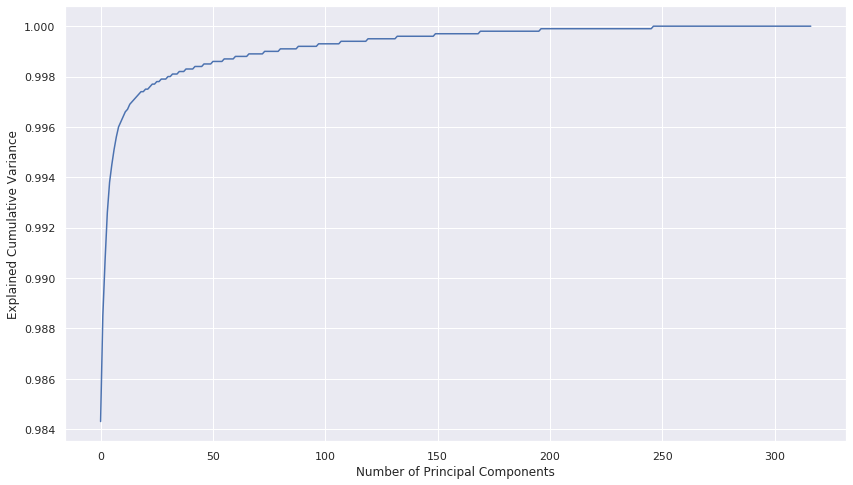

In [14]:
results = pca_results(azdias, pca)
results

In [15]:
n_components = 150
explained_variance = results.iloc[n_components, 0]
explained_variance

0.9997

In [16]:
pca = PCA(n_components=n_components, random_state=777)
azdias_pca = pca.fit_transform(azdias)

In [17]:
print_pcs(azdias, pca, comp=1)

Weights for PC1
Top 5 weights
KBA13_ANZAHL_PKW       0.9999
GEMEINDETYP            0.0073
LP_LEBENSPHASE_FEIN    0.0033
KBA13_GBZ              0.0024
PLZ8_GBZ               0.0023
Name: 0, dtype: float64


Bottom 5 weights
CAMEO_DEU_2015_1             -0.0015
ORTSGR_KLS9                  -0.0015
CAMEO_DEUG_2015              -0.0016
ANZ_STATISTISCHE_HAUSHALTE   -0.0032
ANZ_HAUSHALTE_AKTIV          -0.0037
Name: 0, dtype: float64


In [18]:
print_pcs(azdias, pca, comp=2)

Weights for PC2
Top 5 weights
ANZ_HAUSHALTE_AKTIV           0.6782
ANZ_STATISTISCHE_HAUSHALTE    0.6205
VERDICHTUNGSRAUM              0.0506
CAMEO_DEU_2015_1              0.0464
EINGEZOGENAM_HH_JAHR          0.0447
Name: 1, dtype: float64


Bottom 5 weights
LP_FAMILIE_FEIN       -0.0530
LP_LEBENSPHASE_GROB   -0.0621
LP_STATUS_FEIN        -0.0784
GEMEINDETYP           -0.2110
LP_LEBENSPHASE_FEIN   -0.2225
Name: 1, dtype: float64


In [19]:
print_pcs(azdias, pca, comp=3)

Weights for PC3
Top 5 weights
LP_LEBENSPHASE_FEIN           0.5155
ANZ_HAUSHALTE_AKTIV           0.1901
ANZ_STATISTISCHE_HAUSHALTE    0.1831
GEMEINDETYP                   0.1543
LP_LEBENSPHASE_GROB           0.1438
Name: 2, dtype: float64


Bottom 5 weights
ALTER_HH               -0.0866
VK_DISTANZ             -0.0897
ALTERSKATEGORIE_FEIN   -0.1348
EINGEZOGENAM_HH_JAHR   -0.1697
GEBURTSJAHR            -0.6473
Name: 2, dtype: float64


In [20]:
pca.explained_variance_ratio_.cumsum()

array([0.98433004, 0.98854436, 0.99065285, 0.99260348, 0.99384828,
       0.9945073 , 0.99507584, 0.99559   , 0.99595998, 0.99620532,
       0.99640061, 0.99657441, 0.9967425 , 0.99687641, 0.99699024,
       0.99709368, 0.9971881 , 0.99727835, 0.9973505 , 0.9974196 ,
       0.99748668, 0.99754998, 0.99761025, 0.99766402, 0.99771752,
       0.99776795, 0.9978149 , 0.99786042, 0.99790448, 0.99794781,
       0.99798964, 0.99802685, 0.99806372, 0.99810002, 0.99813503,
       0.99816843, 0.99820074, 0.99823136, 0.99826148, 0.99829065,
       0.99831925, 0.99834664, 0.99837357, 0.99839938, 0.99842455,
       0.99844941, 0.99847334, 0.99849635, 0.99851896, 0.99854123,
       0.99856292, 0.99858404, 0.99860454, 0.99862497, 0.99864502,
       0.99866447, 0.99868317, 0.99870159, 0.99871982, 0.99873755,
       0.99875506, 0.99877233, 0.99878946, 0.99880617, 0.99882249,
       0.99883861, 0.99885457, 0.99887042, 0.99888584, 0.99890091,
       0.9989157 , 0.99893041, 0.99894506, 0.99895953, 0.99897

In [21]:
dump(pca, 'temp/pca.joblib')

['temp/pca.joblib']

In [22]:
scores = []

clusters = list(range(2,16,1))
# Over a number of different cluster counts...
for k in clusters:
    # run k-means clustering on the data and...
    print(f'Running KMeans with {k} cluster(s)')
    start = time() # Get start time
    kmeans = KMeans(n_clusters = k, random_state=777)
    model = kmeans.fit(azdias_pca)
    # compute the average within-cluster distances.
    score = model.score(azdias_pca)
    scores.append(np.abs(score))
    
    end = time() # Get end time
    m, s = divmod(end - start, 60)
    print(f'Finished KMeans with {k} cluster(s) in {m}m:{s}s')

Running KMeans with 2 cluster(s)
Finished KMeans with 2 cluster(s) in 0.0m:21.151911973953247s
Running KMeans with 3 cluster(s)
Finished KMeans with 3 cluster(s) in 0.0m:27.234094381332397s
Running KMeans with 4 cluster(s)
Finished KMeans with 4 cluster(s) in 0.0m:32.6563560962677s
Running KMeans with 5 cluster(s)
Finished KMeans with 5 cluster(s) in 0.0m:34.78263568878174s
Running KMeans with 6 cluster(s)
Finished KMeans with 6 cluster(s) in 0.0m:42.96401405334473s
Running KMeans with 7 cluster(s)
Finished KMeans with 7 cluster(s) in 0.0m:43.439857721328735s
Running KMeans with 8 cluster(s)
Finished KMeans with 8 cluster(s) in 0.0m:48.19861674308777s
Running KMeans with 9 cluster(s)
Finished KMeans with 9 cluster(s) in 0.0m:57.09432768821716s
Running KMeans with 10 cluster(s)
Finished KMeans with 10 cluster(s) in 0.0m:59.640599966049194s
Running KMeans with 11 cluster(s)
Finished KMeans with 11 cluster(s) in 1.0m:7.799067974090576s
Running KMeans with 12 cluster(s)
Finished KMeans wit

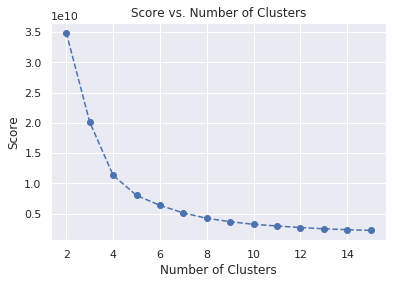

In [23]:
plt.plot(clusters, scores, linestyle='--', marker='o', color='b');
plt.xlabel('Number of Clusters');
plt.ylabel('Score');
plt.title('Score vs. Number of Clusters')
plt.savefig('temp/kmeans.png')
plt.show()

Re-fit the k-means model with the selected number of clusters and obtain cluster predictions for the general population demographics data

In [24]:
kmeans = KMeans(n_clusters = 8, random_state=777)
kmeans = kmeans.fit(azdias_pca)

In [25]:
population_labels = kmeans.labels_

In [26]:
dump(kmeans, 'temp/kmeans_model.joblib')

['temp/kmeans_model.joblib']

In [90]:
try:
    customers = customers.drop('LNR', axis=1)
except:
    pass

In [88]:
try:
    customers_pca = pca.transform(customers)
except:
    nan_values = customers.isna()
    nan_columns = nan_values.any()
    columns_with_nan = customers.columns[nan_columns].tolist()
    temp=pd.read_csv(data_location,sep=';')
    temp[columns_with_nan]=temp[columns_with_nan].astype('int8')
    customers[columns_with_nan] = temp[columns_with_nan]
    try:
        customers.drop(['Unnamed: 0'],axis=1,inplace=True)
    except:
        pass
    customers_pca = pca.transform(customers)

In [91]:
customers_labels = kmeans.predict(customers_pca)


In [92]:

counts_customer = Counter(customers_labels)
n_customers = customers_pca.shape[0]

customer_freqs = {label: 100*(freq / n_customers) for label, freq in counts_customer.items()}

In [93]:

counts_population = Counter(population_labels)
n_population = azdias_pca.shape[0]

population_freqs = {label: 100*(freq / n_population) for label, freq in counts_population.items()}

In [94]:
customer_clusters = pd.DataFrame.from_dict(customer_freqs, orient='index', columns=['% of data'])
customer_clusters['Cluster'] = customer_clusters.index
customer_clusters['DataSet'] = 'Customers Data'
population_clusters = pd.DataFrame.from_dict(population_freqs, orient='index', columns=['% of data'])
population_clusters['Cluster'] = population_clusters.index
population_clusters['DataSet'] = 'General Population'

In [95]:
all_clusters = pd.concat([customer_clusters, population_clusters])
all_clusters

,% of data,Cluster,DataSet
1,6.249870,1,Customers Data
0,44.249473,0,Customers Data
3,15.696679,3,Customers Data
5,13.571473,5,Customers Data
2,3.269989,2,Customers Data
4,6.790954,4,Customers Data
6,9.417590,6,Customers Data
7,0.753971,7,Customers Data
0,31.715029,0,General Population
6,9.923128,6,General Population


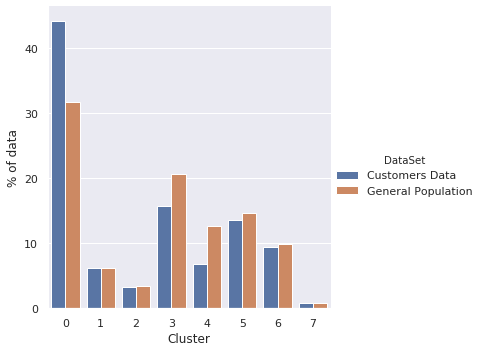

In [96]:
sns.catplot(x='Cluster', y='% of data', hue='DataSet', data=all_clusters, kind='bar')
plt.show()

In [97]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

over_cluster = 7

print(f'Proportion of general population in cluster {over_cluster}: {population_freqs[over_cluster]}%')
print(f'Proportion of customer population in cluster {over_cluster}: {customer_freqs[over_cluster]}%\n')

pc1_avg = (azdias_pca[population_labels == over_cluster][0].sum() + customers_pca[customers_labels == over_cluster][0].sum()) / \
          (n_population + n_customers)

pc2_avg = (azdias_pca[population_labels == over_cluster][1].sum() + customers_pca[customers_labels == over_cluster][1].sum()) / \
          (n_population + n_customers)

pc3_avg = (azdias_pca[population_labels == over_cluster][2].sum() + customers_pca[customers_labels == over_cluster][2].sum()) / \
          (n_population + n_customers)

Proportion of general population in cluster 7: 0.7668131697973903%
Proportion of customer population in cluster 7: 0.7539707386304343%



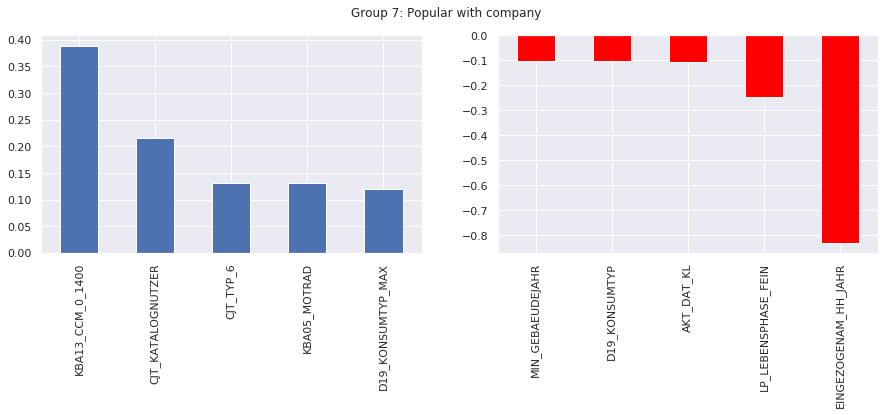

In [98]:
# This line gets the index of the most important PCA feature for over-represented cluster
pca_feat_max = pd.Series(kmeans.cluster_centers_[over_cluster]).sort_values(ascending=False).index[0]
pca_feat_min = pd.Series(kmeans.cluster_centers_[over_cluster]).sort_values(ascending=True).index[0]

# This line plots the PCA components weights against one another
fig = comp_weights(pca, pca_feat_max, pca_feat_min, 5, customers)
plt.suptitle(f'Group {over_cluster}: Popular with company');
plt.savefig('temp/over_cluster.png', dpi=fig.dpi, bbox_inches='tight')

In [104]:
pca_inverse = pca.inverse_transform(kmeans.cluster_centers_[over_cluster,:])
df = pd.DataFrame(pca_inverse[np.newaxis], columns=customers.columns)

#scaler = clean_pipeline.named_steps['transform_pipeline'].transformers_[2][1].named_steps['std_scaler']
#df[numeric_features] = scaler.inverse_transform(df[numeric_features])

popular_features = ['KBA13_CCM_0_1400', 'CJT_KATALOGNUTZER', 'CJT_TYP_6', 'KBA05_MOTRAD', 'D19_KONSUMTYP_MAX']
print('Popular with company')
df[popular_features]

Popular with company


,KBA13_CCM_0_1400,CJT_KATALOGNUTZER,CJT_TYP_6,KBA05_MOTRAD,D19_KONSUMTYP_MAX
0,2.195429,3.290462,3.609294,1.206609,5.189276


In [105]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

under_cluster = 4

print(f'Proportion of general population in cluster {under_cluster}: {population_freqs[under_cluster]}%')
print(f'Proportion of customer population in cluster {under_cluster}: {customer_freqs[under_cluster]}%\n')

pc1_avg = (azdias_pca[population_labels == under_cluster][0].sum() + customers_pca[customers_labels == under_cluster][0].sum()) / \
          (n_population + n_customers)

pc2_avg = (azdias_pca[population_labels == under_cluster][1].sum() + customers_pca[customers_labels == under_cluster][1].sum()) / \
          (n_population + n_customers)

pc3_avg = (azdias_pca[population_labels == under_cluster][2].sum() + customers_pca[customers_labels == under_cluster][2].sum()) / \
          (n_population + n_customers)


Proportion of general population in cluster 4: 12.72063831530002%
Proportion of customer population in cluster 4: 6.790954438252666%



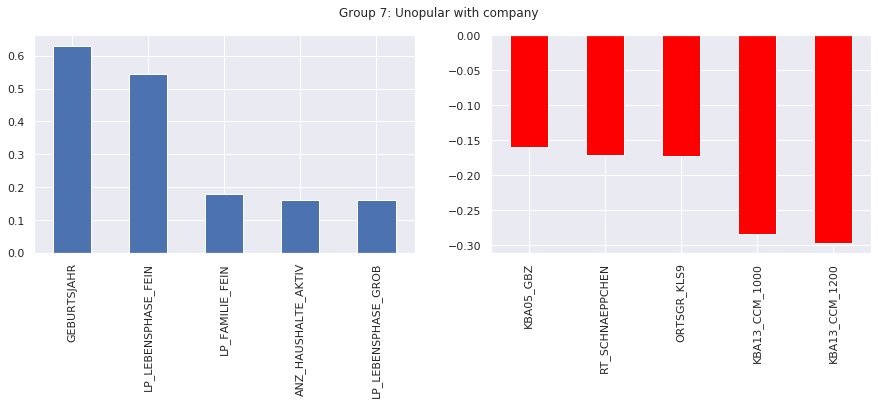

In [106]:
# This line gets the index of the most important PCA feature for over-represented cluster
pca_feat_max = pd.Series(kmeans.cluster_centers_[under_cluster]).sort_values(ascending=False).index[0]
pca_feat_min = pd.Series(kmeans.cluster_centers_[under_cluster]).sort_values(ascending=True).index[0]

# This line plots the PCA components weights against one another
fig = comp_weights(pca, pca_feat_max, pca_feat_min, 5, customers)
plt.suptitle(f'Group {over_cluster}: Unopular with company');
plt.savefig('temp/under_cluster.png', dpi=fig.dpi, bbox_inches='tight')

In [110]:

pca_inverse = pca.inverse_transform(kmeans.cluster_centers_[under_cluster,:])
df = pd.DataFrame(pca_inverse[np.newaxis], columns=customers.columns)

#scaler = clean_pipeline.named_steps['transform_pipeline'].transformers_[2][1].named_steps['std_scaler']
#df[numeric_features] = scaler.inverse_transform(df[numeric_features])

unpopular_features = ['GEBURTSJAHR', 
                      'LP_LEBENSPHASE_FEIN', 
                      'LP_FAMILIE_FEIN', 
                      'ANZ_HAUSHALTE_AKTIV', 
                      'LP_LEBENSPHASE_GROB']
print('Unpopular with company')
df[unpopular_features]

Unpopular with company


,GEBURTSJAHR,LP_LEBENSPHASE_FEIN,LP_FAMILIE_FEIN,ANZ_HAUSHALTE_AKTIV,LP_LEBENSPHASE_GROB
0,1967.660858,14.104268,3.532331,10.318003,4.452765


# Results - Compare Customer Data to Demographics Data
> Popular with company - Cluster 7

 - S'KBA13_CCM_0_1400'
 - 'CJT_KATALOGNUTZER'
 - 'CJT_TYP_6'
 - 'KBA05_MOTRAD'
 - 'D19_KONSUMTYP_MAX'

> Unpopular with company - Cluster 4
 - 'GEBURTSJAHR' 
 - 'LP_LEBENSPHASE_FEIN' 
 - 'LP_FAMILIE_FEIN'
 - 'ANZ_HAUSHALTE_AKTIV'
 - 'LP_LEBENSPHASE_GROB'